
### Complete workflow example using WatershedGeo:
1. Load MODFLOW water content data
2. Convert to resistivity model using petrophysical relationships
3. Perform forward ERT simulation
4. Conduct inversion to recover the resistivity model


In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import ert
from mpl_toolkits.axes_grid1 import make_axes_locatable


# For Jupyter notebooks, use the current working directory
try:
    # For regular Python scripts
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # For Jupyter notebooks
    current_dir = os.getcwd()
# Add the parent directory (OPEN_ERT) to the path
parent_dir = os.path.dirname(os.path.dirname(current_dir))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Now you can import using the structure as you originally intended
from watershed_geophysics.modflow.water_content import MODFLOWWaterContent
from watershed_geophysics.core.interpolation import ProfileInterpolator,create_surface_lines
from watershed_geophysics.core.mesh_utils import MeshCreator
from watershed_geophysics.petrophysics.resistivity_models import water_content_to_resistivity
from watershed_geophysics.forward.ert_forward import ERTForwardModeling
from watershed_geophysics.inversion.ert_inversion import ERTInversion

In [2]:
output_dir = "results/workflow_example"
os.makedirs(output_dir, exist_ok=True)

In [3]:
print("Step 1: Loading domain information...")

# These would be your actual data files
data_dir = "data/"
modflow_dir = os.path.join(data_dir, "modflow")

# Load domain information from files
# (Replace with your actual file paths)
idomain = np.loadtxt(os.path.join(data_dir, "id.txt"))
top = np.loadtxt(os.path.join(data_dir, "top.txt"))
porosity = np.load(os.path.join(data_dir, "Porosity.npy"))

Step 1: Loading domain information...


In [4]:
# Step 2: Exmaple of loading MODFLOW water content data
print("Step 2: Loading MODFLOW water content data...")

# Initialize MODFLOW water content processor
water_content_processor = MODFLOWWaterContent(
    sim_ws=modflow_dir,
    idomain=idomain
    )

# Load water content for a specific timestep
timestep = 10
water_content = water_content_processor.load_timestep(timestep)

print(water_content.shape)



# note that to save the loading time, we only use a low resoluation model load for the example
# In a real-world application, you would load the full resolution data
# here we will load the npy file for the water content to save time

# Load the water content from a .npy file for demonstration purposes

Water_Content = np.load(os.path.join(data_dir, "Watercontent.npy"))

water_content = Water_Content[50]
print(water_content.shape)

Step 2: Loading MODFLOW water content data...
(3, 194, 157)
(14, 194, 157)


In [5]:
Water_Content.shape

(365, 14, 194, 157)

In [28]:
porosity.shape

(14, 194, 157)

In [6]:
# Step 3: Set up profile for 2D section
print("Step 3: Setting up profile...")

# Define profile endpoints
point1 = [115, 70]  # [col, row]
point2 = [95, 180]  # [col, row]

# Initialize profile interpolator
interpolator = ProfileInterpolator(
    point1=point1,
    point2=point2,
    surface_data=top,
    origin_x=569156.2983333333,
    origin_y=4842444.17,
    pixel_width=1.0,
    pixel_height=-1.0
)

Step 3: Setting up profile...


In [7]:
# Step 4: Interpolate data to profile
print("Step 4: Interpolating data to profile...")

# Interpolate water content to profile
water_content_profile = interpolator.interpolate_3d_data(water_content)

# Interpolate porosity to profile
porosity_profile = interpolator.interpolate_3d_data(porosity)

Step 4: Interpolating data to profile...


In [8]:
np.nanmax(water_content/porosity)

1.0

In [9]:
print("Step 5: Creating mesh...")

# Load structure layers
bot = np.load(os.path.join(data_dir, "bot.npy"))

# Process layers to get structure
structure = interpolator.interpolate_layer_data([top] + bot.tolist())

# Create surface lines
# Indicate the layer for the structure regolith, fractured bedrock and fresh bedrock
top_idx=int(0)
mid_idx=int(4)
bot_idx=int(12)
surface, line1, line2 = create_surface_lines(
    L_profile=interpolator.L_profile,
    structure=structure,
    top_idx=0,
    mid_idx=4,
    bot_idx=12
)

# Create mesh
mesh_creator = MeshCreator(quality=32)
mesh = mesh_creator.create_from_layers(
    surface=surface,
    layers=[line1, line2],
    bottom_depth= np.min(line2[:,1])-10#50.0
)

# Save mesh
mesh.save(os.path.join(output_dir, "mesh.bms"))

Step 5: Creating mesh...


1

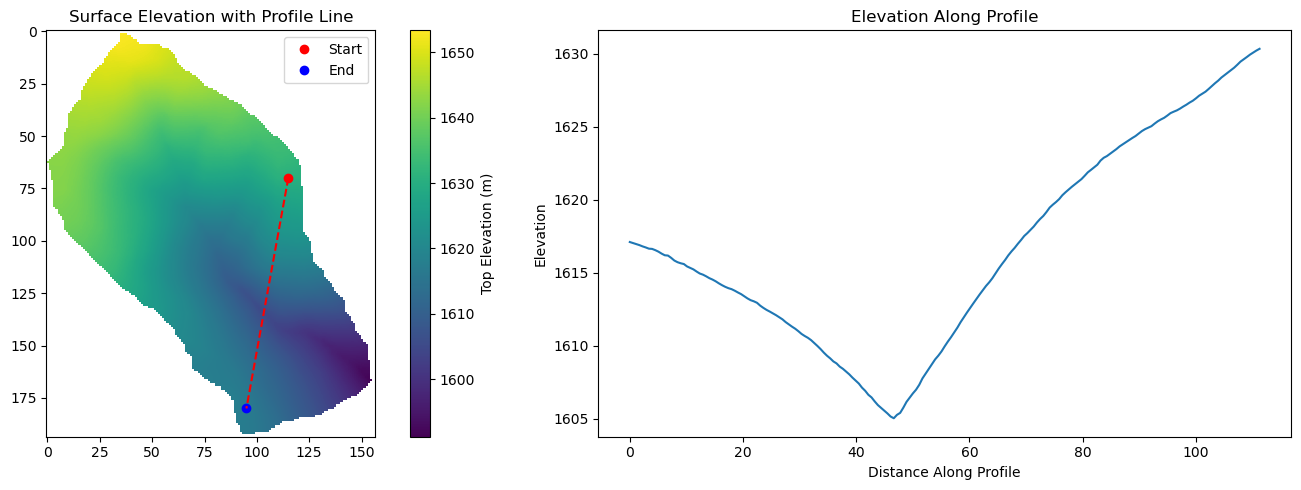

In [10]:


# Visualize the result
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
top[idomain==0] = np.nan  # Mask out the inactive cells in the top layer
# Plot the surface and profile line
plt.subplot(121)
plt.imshow(top)
plt.colorbar(label='Top Elevation (m)')
plt.plot(point1[0], point1[1], 'ro', label='Start')
plt.plot(point2[0], point2[1], 'bo', label='End')
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'r--')
plt.legend()
plt.title('Surface Elevation with Profile Line')

# Plot the profile coordinates
plt.subplot(122)
plt.plot(surface[:,0], surface[:,1])
plt.title('Elevation Along Profile')
plt.xlabel('Distance Along Profile')
plt.ylabel('Elevation')

plt.tight_layout()
plt.show()

In [11]:
# Step 6: Interpolate data to mesh
print("Step 6: Interpolating data to mesh...")

ID1 = porosity_profile.copy()
ID1[:mid_idx] = 0 #regolith
ID1[mid_idx:bot_idx] = 3 # fractured bedrock
ID1[bot_idx:] = 2 # fresh bedrock

# Get mesh centers and markers
mesh_centers = np.array(mesh.cellCenters())
mesh_markers = np.array(mesh.cellMarkers())

# Interpolate porosity to mesh
porosity_mesh = interpolator.interpolate_to_mesh(
    property_values=porosity_profile,
    depth_values=structure,
    mesh_x=mesh_centers[:, 0],
    mesh_y=mesh_centers[:, 1],
    mesh_markers=mesh_markers,
    ID=ID1, # Use ID1 to indicate the layers for interpolation
    layer_markers = [0,3,2],

)

# Interpolate water content to mesh
wc_mesh = interpolator.interpolate_to_mesh(
    property_values=water_content_profile,
    depth_values=structure,
    mesh_x=mesh_centers[:, 0],
    mesh_y=mesh_centers[:, 1],
    mesh_markers=mesh_markers,
    ID=ID1, # Use ID1 to indicate the layers for interpolation
    layer_markers = [0,3,2],

)

Step 6: Interpolating data to mesh...


In [12]:
len([0,0,0,0,3,3,3,3,3,3,3,3,2,2])

14

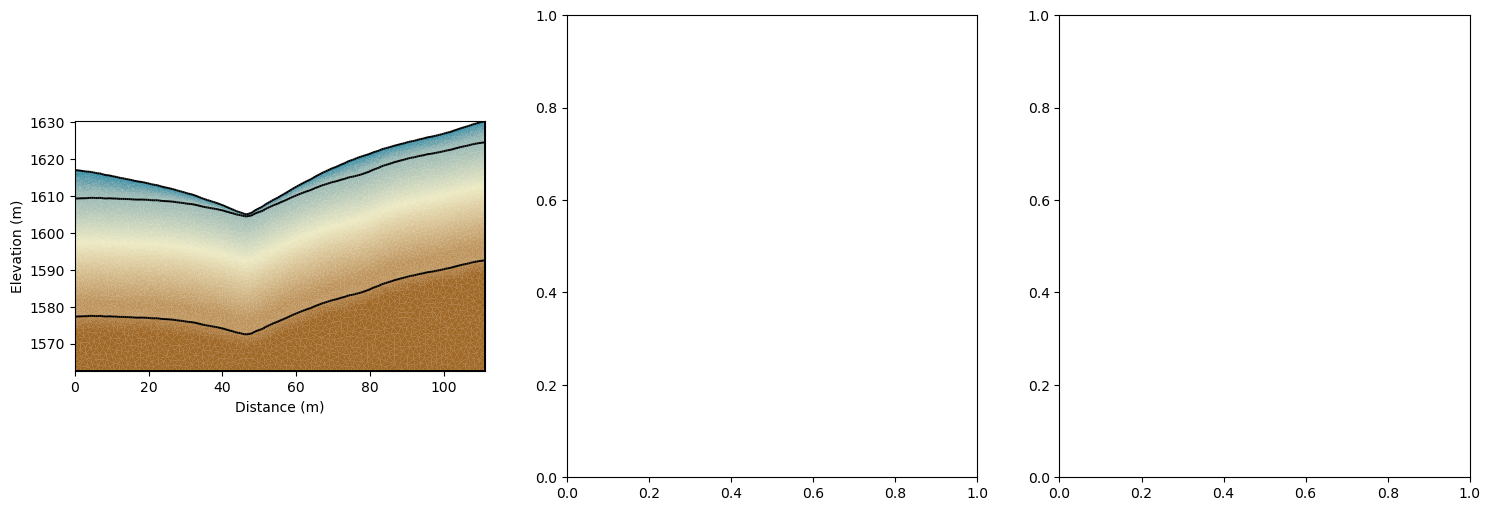

<Figure size 640x480 with 0 Axes>

In [13]:
saturation = wc_mesh / porosity_mesh

# Color map, this should be defined or replaced with an existing colormap variable
from palettable.cartocolors.diverging import Earth_7
ctcolor = Earth_7.mpl_colormap

# Create figure with 3 subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Porosity subplot
pg.show(mesh, porosity_mesh, 
        orientation="vertical", cMap=ctcolor, 
        cMin=0.05, cMax=0.45, 
        xlabel="Distance (m)", ylabel="Elevation (m)",
        label='Porosity (-)', ax=axs[0], showColorBar=True)

# Water content subplot - adjust cMin and cMax as needed
pg.show(mesh, wc_mesh, 
        orientation="vertical", cMap=ctcolor, 
        cMin=np.min(wc_mesh), cMax=np.max(wc_mesh), 
        xlabel="Distance (m)", ylabel="Elevation (m)",
        label='Water Content (-)', ax=axs[1], showColorBar=True)

# Saturation subplot
pg.show(mesh, saturation, 
        orientation="vertical", cMap=ctcolor, 
        cMin=0, cMax=1,   # Adjust these limits if needed
        xlabel="Distance (m)", ylabel="Elevation (m)",
        label='Saturation (-)', ax=axs[2], showColorBar=True)

plt.tight_layout()
plt.show()

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1dfe5220e10>)

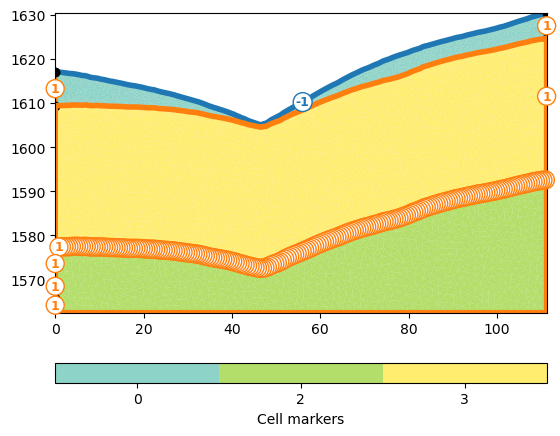

In [14]:
pg.show(mesh,markers=True)

In [15]:
print("Step 7: Calculating saturation...")

# Ensure porosity is not zero to avoid division by zero
porosity_safe = np.maximum(porosity_mesh, 0.01)
saturation = np.clip(wc_mesh / porosity_safe, 0.0, 1.0)


Step 7: Calculating saturation...


In [16]:

# Step 8: Convert to resistivity using petrophysical model
print("Step 8: Converting to resistivity...")

marker_labels = [0, 3, 2] # top. mid, bottom layers (example values)
rho_sat = [100, 500, 2400] # Saturated resistivity for each layer (example values)
n = [2.2, 1.8, 2.5] # Cementation exponent for each layer (example values)
sigma_s = [1/500, 0, 0] # Saturated resistivity of the surface conductivity see Chen & Niu, (2022) for each layer (example values)
# Convert water content back to resistivity

res_models = np.zeros_like(wc_mesh)  # Initialize an array for resistivity values

mask = (mesh_markers == marker_labels[0])
top_res = water_content_to_resistivity(
    wc_mesh[mask],                  # Water content values for this layer
    float(rho_sat[0]),              # Use a scalar value instead of an array
    float(n[0]),                    # Use a scalar value instead of an array
    porosity_mesh[mask],            # Porosity values for this layer
    sigma_s[0] # Use a scalar value
)
res_models[mask] = top_res

mask = (mesh_markers == marker_labels[1])
mid_res = water_content_to_resistivity(
    wc_mesh[mask],                  # Water content values for this layer
    float(rho_sat[1]),              # Use a scalar value instead of an array
    float(n[1]),                    # Use a scalar value instead of an array
    porosity_mesh[mask],            # Porosity values for this layer
    sigma_s[1]  # Use a scalar value
)
res_models[mask] = mid_res


mask = (mesh_markers == marker_labels[2])
bot_res = water_content_to_resistivity(
    wc_mesh[mask],                  # Water content values for this layer
    float(rho_sat[2]),              # Use a scalar value instead of an array
    float(n[2]),                    # Use a scalar value instead of an array
    porosity_mesh[mask],            # Porosity values for this layer
    sigma_s[2]
)
res_models[mask] = bot_res


Step 8: Converting to resistivity...


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1dfe685f410>)

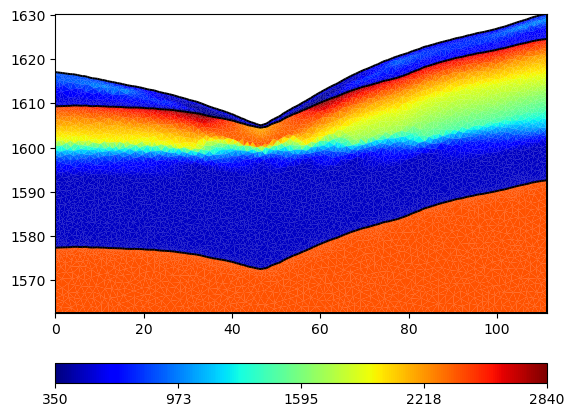

In [17]:
pg.show(mesh,res_models, cMap='jet', colorbar=True,logscale=True)

In [18]:
# Step 9: Create ERT survey design
print("Step 9: Creating ERT survey design...")



xpos = np.linspace(15,15+72 - 1,72)
ypos = np.interp(xpos,interpolator.L_profile,interpolator.surface_profile)
pos = np.hstack((xpos.reshape(-1,1),ypos.reshape(-1,1)))

schemeert = ert.createData(elecs=pos,schemeName='wa')

Step 9: Creating ERT survey design...


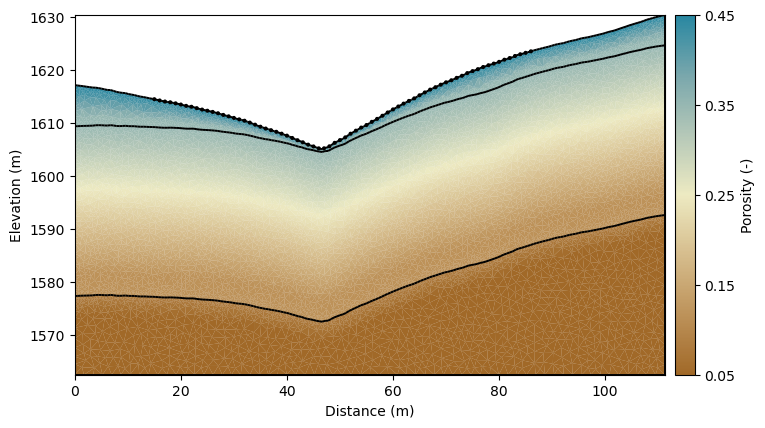

In [19]:
fig = plt.figure(figsize=[8,6])


ax = fig.add_subplot(1,1,1)
from palettable.cartocolors.diverging import Earth_7
ctcolor = Earth_7.mpl_colormap
pg.show(mesh, porosity_mesh,orientation="vertical",cMap = ctcolor,cMin = 0.05, cMax = 0.45 ,xlabel="Distance (m)", ylabel="Elevation (m)"
       ,label='Porosity (-)',ax = ax)
pg.viewer.mpl.drawSensors(ax, schemeert.sensors(), diam=0.5,
                         facecolor='black', edgecolor='black')


In [20]:
# Step 10: Forward modeling to create synthetic ERT data
print("Step 10: Performing forward modeling...")
mesh.setCellMarkers(np.ones(mesh.cellCount())*2)
grid = pg.meshtools.appendTriangleBoundary(mesh, marker=1,
                                          xbound=100, ybound=100)

fwd_operator = ERTForwardModeling(mesh=grid, data=schemeert)
# ax,_ = pg.show(grid,markers=True)

Step 10: Performing forward modeling...


07/04/25 - 13:48:29 - pyGIMLi - INFO - Found 2 regions.
07/04/25 - 13:48:29 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.


In [21]:
synth_data = schemeert.copy()
fob = ert.ERTModelling()
fob.setData(schemeert)
fob.setMesh(grid)
dr = fob.response(res_models)
# dataert = ert.simulate(grid, scheme=schemeert, res=res_models, noiseLevel=0,
#                     noiseAbs=0,seed=1001)

# ert.showData(dataert)

07/04/25 - 13:48:29 - pyGIMLi - INFO - Found 2 regions.
07/04/25 - 13:48:29 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/04/25 - 13:48:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/04/25 - 13:48:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
07/04/25 - 13:48:30 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 23852 Cells: 47252 Boundaries: 35664


1

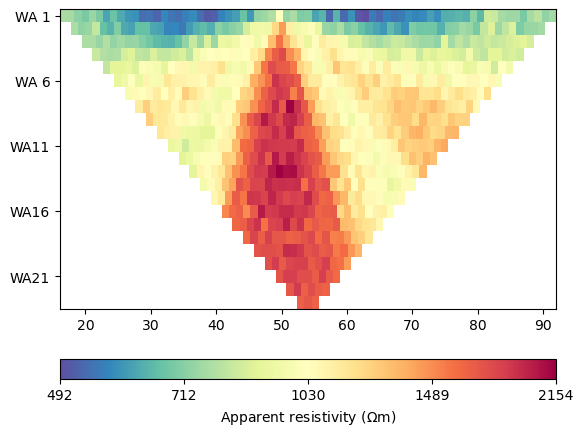

In [22]:
dr *= 1. + pg.randn(dr.size()) * 0.05
ert_manager = ert.ERTManager(synth_data)
synth_data['rhoa'] = dr
synth_data['err'] = ert_manager.estimateError(synth_data, absoluteUError=0.0, relativeError=0.05)
ert.showData(synth_data,  logscale=True)
synth_data.save(os.path.join(output_dir, "synthetic_data.dat"))

In [23]:
# Step 11: Run ERT inversion on synthetic data

## using my code to the inversion
print("Step 11: Running ERT inversion...")

# Create ERT inversion object
inversion = ERTInversion(
    data_file=os.path.join(output_dir, "synthetic_data.dat"),
    lambda_val=10.0,
    method="cgls",
    use_gpu=True,
    max_iterations=10,
    lambda_rate= 1.0
)
inversion_result = inversion.run()

07/04/25 - 13:50:44 - pyGIMLi - INFO - Found 2 regions.
07/04/25 - 13:50:44 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/04/25 - 13:50:45 - pyGIMLi - INFO - Found 2 regions.
07/04/25 - 13:50:45 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/04/25 - 13:50:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/04/25 - 13:50:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
07/04/25 - 13:50:45 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3986 Cells: 7596 Boundaries: 5884


Step 11: Running ERT inversion...
-------------------Iteration: 0 ---------------------------
chi2: [[31.83925342]]
dPhi: 1.0
-------------------Iteration: 1 ---------------------------
chi2: [[2.76803853]]
dPhi: [[0.91306208]]
-------------------Iteration: 2 ---------------------------
chi2: [[1.11243511]]
dPhi: [[0.5981143]]
End of inversion


In [24]:
inversion_result.mesh

Mesh: Nodes: 774 Cells: 1364 Boundaries: 182

In [25]:
inversion_result.final_model.shape

(1364,)

In [26]:
## Using Pygimili default to the inversion
mgr = ert.ERTManager(os.path.join(output_dir, "synthetic_data.dat"))
inv = mgr.invert(lam=10, verbose=True,quality=34)

07/04/25 - 13:51:08 - pyGIMLi - INFO - Found 2 regions.
07/04/25 - 13:51:08 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/04/25 - 13:51:08 - pyGIMLi - INFO - Found 2 regions.
07/04/25 - 13:51:08 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/04/25 - 13:51:08 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/04/25 - 13:51:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
07/04/25 - 13:51:08 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3986 Cells: 7596 Boundaries: 5884
07/04/25 - 13:51:08 - pyGIMLi - INFO - Use median(data values)=1088.451589401675
07/04/25 - 13:51:08 - pyGIMLi - INFO - Created startmodel from forward operator: 1364, min/max=1088.451589/1088.451589
07/04/25 - 13:51:08 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001DEE09D2660>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001DEE09D0950>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001DEE09D06D0>
min/max (data): 492/2154
min/max (error): 5%/5%
min/max (start model): 1088/1088
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   30.32
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    2.63 (dPhi = 90.56%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.05 (dPhi = 53.80%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.00 (dPhi = 3.68%) lam: 10.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (1.00)            

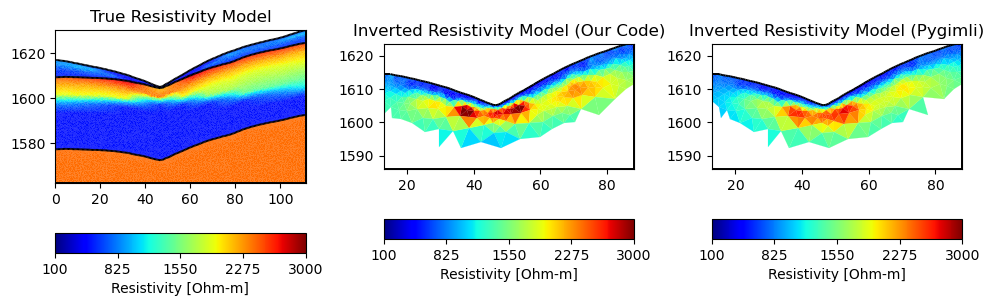

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(10, 12))

# True resistivity model
ax1 = axes[0]
cbar1 = pg.show(mesh, res_models, ax=ax1, cMap='jet', logScale=False, 
              cMin=100, cMax=3000, label='Resistivity [Ohm-m]')
ax1.set_title("True Resistivity Model")

# Inverted model
ax2 = axes[1]
cbar2 = pg.show(inversion_result.mesh, inversion_result.final_model, ax=ax2, cMap='jet', logScale=False, 
              cMin=100, cMax=3000, label='Resistivity [Ohm-m]',coverage=inversion_result.coverage>-1)
ax2.set_title("Inverted Resistivity Model (Our Code)")

ax3 = axes[2]
cbar2 = pg.show(mgr.paraDomain, mgr.paraModel(), ax=ax3, cMap='jet', logScale=False, 
              cMin=100, cMax=3000, label='Resistivity [Ohm-m]',coverage=mgr.coverage()>-1)
ax3.set_title("Inverted Resistivity Model (Pygimli)")
# Adjust layout
plt.tight_layout()



# The inversion results are almost same from this code and Pygimli default inversion.
# the difference is that the chi2 value for stop inversion is not the same, we chose 1.5 while Pygimli is 1.0